# 14.1f: Temperature Distributions and Cosmic Rays

**The primordial atom isn't at thermal equilibrium.**

## The Problem with Means

Every training step, the velocity distribution is **bimodal**:
- **One token** (the correct prediction) gets a huge kick → escapes at high velocity
- **All other tokens** (~127) get gentle penalization → drift slowly

Taking the mean velocity conflates these two populations. It's like measuring the temperature of a room by averaging in the temperature of a blowtorch pointed at one spot.

## The Cosmic Ray Analogy

Each step, one token gets hit by a "cosmic ray" (large gradient from being the correct prediction) and flies off. The rest experience ambient radiation (small penalty gradients).

**Dead tokens never get cosmic ray hits** — they're never the correct token. So their velocity distribution is unimodal and tells us the **true ambient temperature** of hidden space.

## This Notebook

We'll look at temperature through multiple lenses:
1. **Dead token temperature** (ambient, cosmic-ray-free)
2. **Velocity distributions** (median, 90th percentile, max)
3. **Live vs dead comparison** (how much does the cosmic ray contaminate the signal?)
4. **Heatmap of velocity evolution** (watch the distribution change over time)

## Parameters

In [1]:
# Data
DATA_PATH = "../data/instrumented_run/gradient_delta_history.safetensors"

# Analysis
VELOCITY_BINS = 100  # For heatmap
PERCENTILES = [50, 90, 95, 99]  # Which percentiles to track

# Visualization
DPI = 100

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from safetensors.torch import load_file

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print(f"Loading: {DATA_PATH}")

data = load_file(DATA_PATH)

recorded_steps = data['recorded_steps'].numpy()
dead_token_ids = data['dead_token_ids'].tolist()
live_token_ids = data['live_token_ids'].tolist()

dead_deltas = data['dead_deltas']  # [n_recorded, n_dead, hidden_dim]
live_deltas = data['live_deltas']  # [n_recorded, n_live, hidden_dim]

n_recorded = len(recorded_steps)
n_dead = len(dead_token_ids)
n_live = len(live_token_ids)

print(f"\n  Recorded steps: {n_recorded}")
print(f"  Step range: {recorded_steps[0]} to {recorded_steps[-1]}")
print(f"  Dead tokens: {n_dead}")
print(f"  Live tokens: {n_live}")
print(f"\n✓ Data loaded")

Loading: ../data/instrumented_run/gradient_delta_history.safetensors

  Recorded steps: 1001
  Step range: 0 to 10000
  Dead tokens: 51
  Live tokens: 10

✓ Data loaded


## Compute Velocities (L2 norm)

In [4]:
print("Computing velocities...")

# L2 norms of deltas = velocity
dead_velocities = torch.norm(dead_deltas, p=2, dim=2)  # [n_recorded, n_dead]
live_velocities = torch.norm(live_deltas, p=2, dim=2)  # [n_recorded, n_live]

# Combined
all_velocities = torch.cat([dead_velocities, live_velocities], dim=1)  # [n_recorded, n_dead + n_live]

print(f"✓ Velocities computed")
print(f"  Dead: {dead_velocities.shape}")
print(f"  Live: {live_velocities.shape}")
print(f"  All: {all_velocities.shape}")

Computing velocities...
✓ Velocities computed
  Dead: torch.Size([1001, 51])
  Live: torch.Size([1001, 10])
  All: torch.Size([1001, 61])


## Plot 1: Dead Token Temperature (Cosmic-Ray-Free)

Dead tokens never get the big kick, so their temperature measures pure ambient thermal agitation.

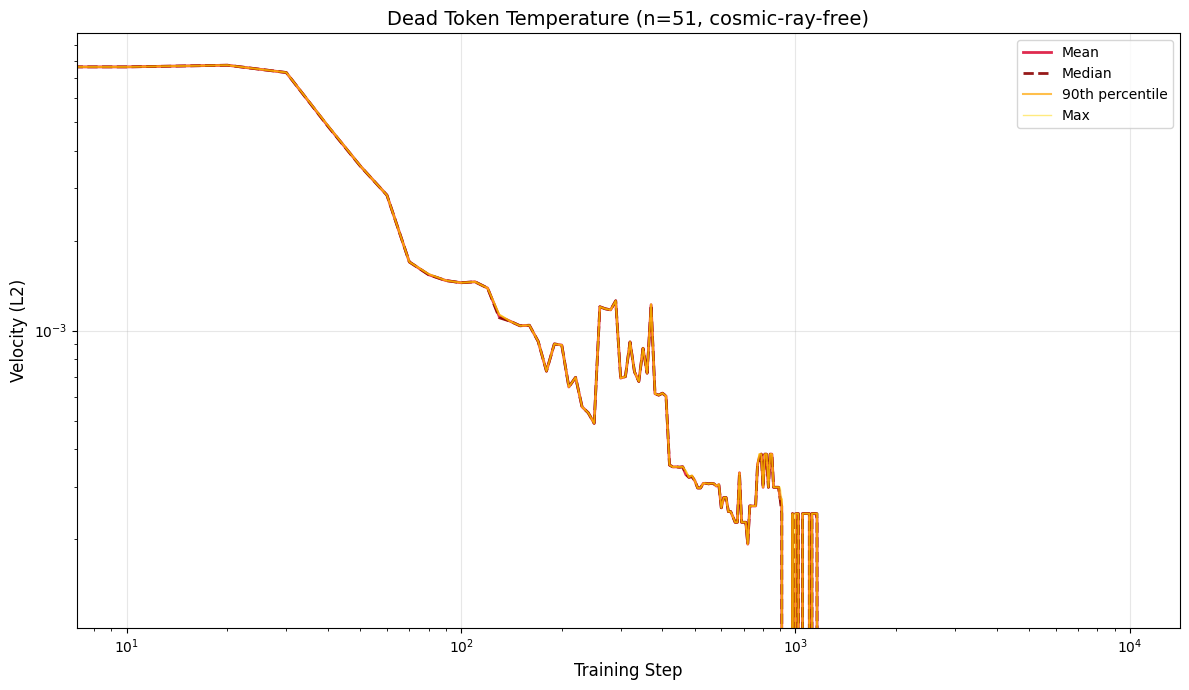


✓ Dead token temperature plot complete


In [5]:
# Statistics for dead tokens
dead_mean = dead_velocities.mean(dim=1).numpy()
dead_median = dead_velocities.median(dim=1)[0].numpy()
dead_p90 = np.percentile(dead_velocities.numpy(), 90, axis=1)
dead_max = dead_velocities.max(dim=1)[0].numpy()

fig, ax = plt.subplots(figsize=(12, 7), dpi=DPI)

ax.plot(recorded_steps, dead_mean, linewidth=2, color='crimson', label='Mean', alpha=0.9)
ax.plot(recorded_steps, dead_median, linewidth=2, color='darkred', label='Median', alpha=0.9, linestyle='--')
ax.plot(recorded_steps, dead_p90, linewidth=1.5, color='orange', label='90th percentile', alpha=0.7)
ax.plot(recorded_steps, dead_max, linewidth=1, color='gold', label='Max', alpha=0.5)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Velocity (L2)', fontsize=12)
ax.set_title(f'Dead Token Temperature (n={n_dead}, cosmic-ray-free)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Dead token temperature plot complete")

## Plot 2: Live Token Temperature (Cosmic-Ray-Contaminated)

Live tokens occasionally get huge kicks. Mean is inflated; median is more robust.

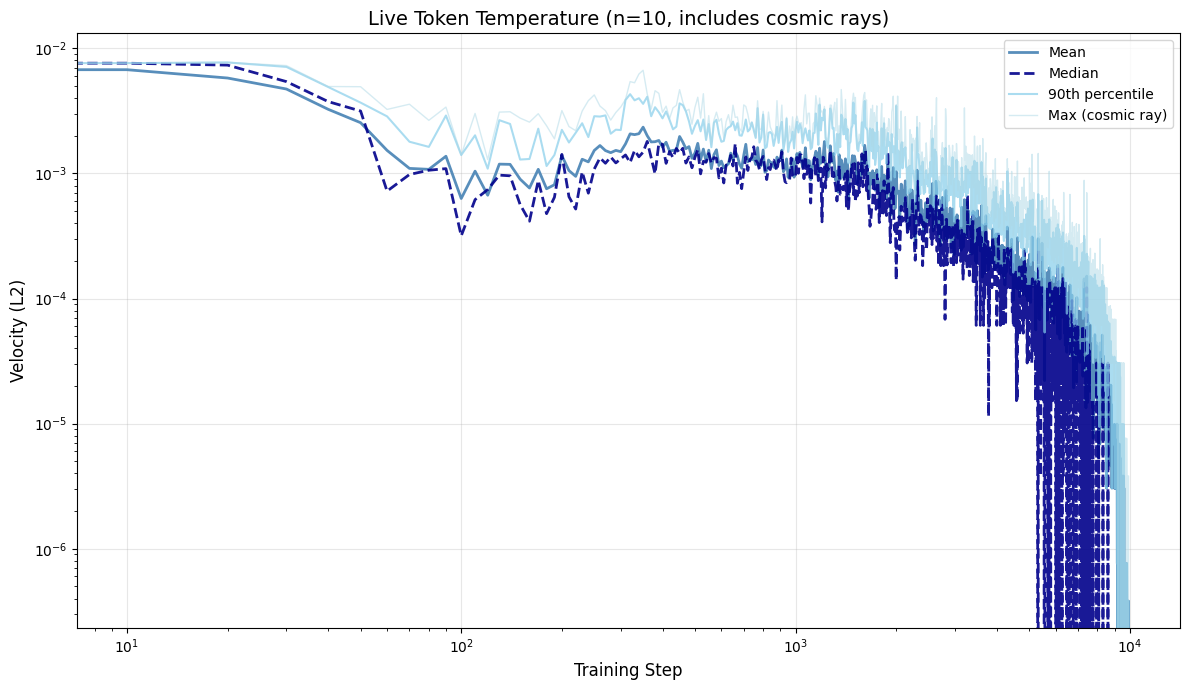


✓ Live token temperature plot complete


In [6]:
# Statistics for live tokens
live_mean = live_velocities.mean(dim=1).numpy()
live_median = live_velocities.median(dim=1)[0].numpy()
live_p90 = np.percentile(live_velocities.numpy(), 90, axis=1)
live_max = live_velocities.max(dim=1)[0].numpy()

fig, ax = plt.subplots(figsize=(12, 7), dpi=DPI)

ax.plot(recorded_steps, live_mean, linewidth=2, color='steelblue', label='Mean', alpha=0.9)
ax.plot(recorded_steps, live_median, linewidth=2, color='darkblue', label='Median', alpha=0.9, linestyle='--')
ax.plot(recorded_steps, live_p90, linewidth=1.5, color='skyblue', label='90th percentile', alpha=0.7)
ax.plot(recorded_steps, live_max, linewidth=1, color='lightblue', label='Max (cosmic ray)', alpha=0.5)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Velocity (L2)', fontsize=12)
ax.set_title(f'Live Token Temperature (n={n_live}, includes cosmic rays)', fontsize=14)
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n✓ Live token temperature plot complete")

## Plot 3: Direct Comparison (Median Temperature)

Median is robust to outliers. How do dead and live tokens compare?

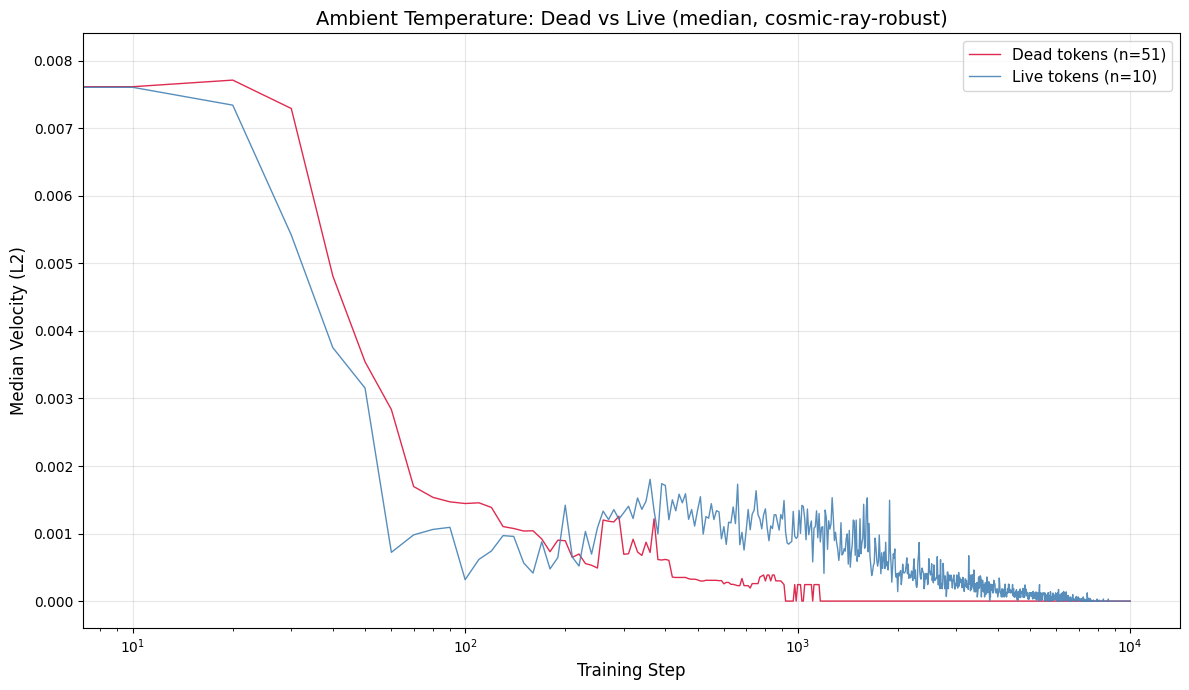


✓ Median comparison plot complete


In [15]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=DPI)

ax.plot(recorded_steps, dead_median, linewidth=1, color='crimson', label=f'Dead tokens (n={n_dead})', alpha=0.9)
ax.plot(recorded_steps, live_median, linewidth=1, color='steelblue', label=f'Live tokens (n={n_live})', alpha=0.9)

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Median Velocity (L2)', fontsize=12)
ax.set_title('Ambient Temperature: Dead vs Live (median, cosmic-ray-robust)', fontsize=14)
ax.legend(loc='best', fontsize=11)
ax.grid(alpha=0.3)
ax.set_xscale('log')
ax.set_yscale('linear')

plt.tight_layout()
plt.show()

print(f"\n✓ Median comparison plot complete")

## Plot 4: Velocity Distribution Heatmap (Dead Tokens)

Show how the full velocity distribution evolves over time. Should be unimodal and cooling.

Building velocity distribution heatmap for dead tokens...


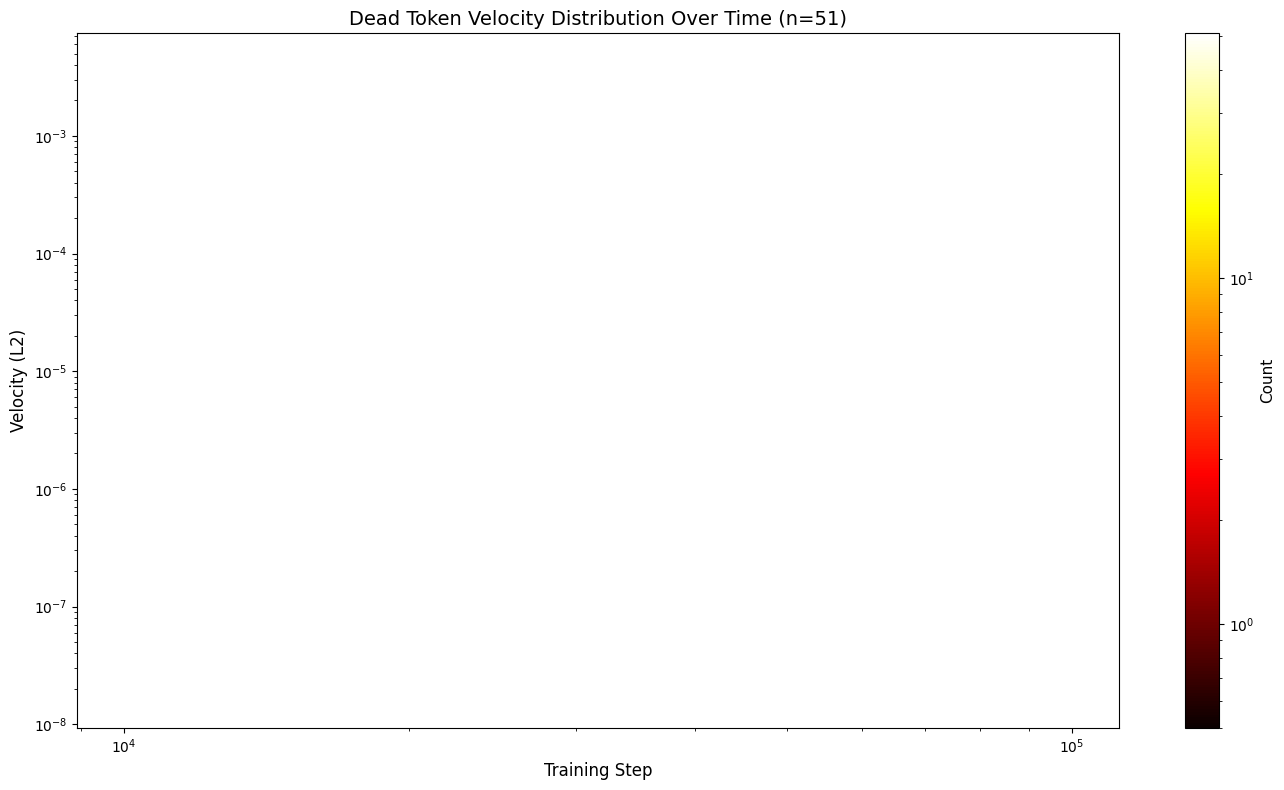


✓ Heatmap complete


In [16]:
print("Building velocity distribution heatmap for dead tokens...")

# Find velocity range for binning
v_min = dead_velocities.min().item()
v_max = dead_velocities.max().item()

# Use log-spaced bins (velocities span many orders of magnitude)
# Add small epsilon to handle zeros
epsilon = 1e-8
bins = np.logspace(np.log10(v_min + epsilon), np.log10(v_max + epsilon), VELOCITY_BINS)

# Compute histogram at each timestep
heatmap = np.zeros((n_recorded, VELOCITY_BINS - 1))

for t in range(n_recorded):
    velocities_at_t = dead_velocities[t].numpy()
    hist, _ = np.histogram(velocities_at_t, bins=bins)
    heatmap[t] = hist

# Plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

# Use log scale for color to see structure
im = ax.pcolormesh(recorded_steps, bins[:-1], heatmap.T, 
                    cmap='hot', norm=LogNorm(vmin=0.5, vmax=heatmap.max()), 
                    shading='auto')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Velocity (L2)', fontsize=12)
ax.set_title(f'Dead Token Velocity Distribution Over Time (n={n_dead})', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n✓ Heatmap complete")

## Plot 5: Velocity Distribution Heatmap (All Tokens)

For comparison: all tokens including live ones. Should show bimodal structure (most tokens cold, occasional hot outlier).

Building velocity distribution heatmap for all tokens...


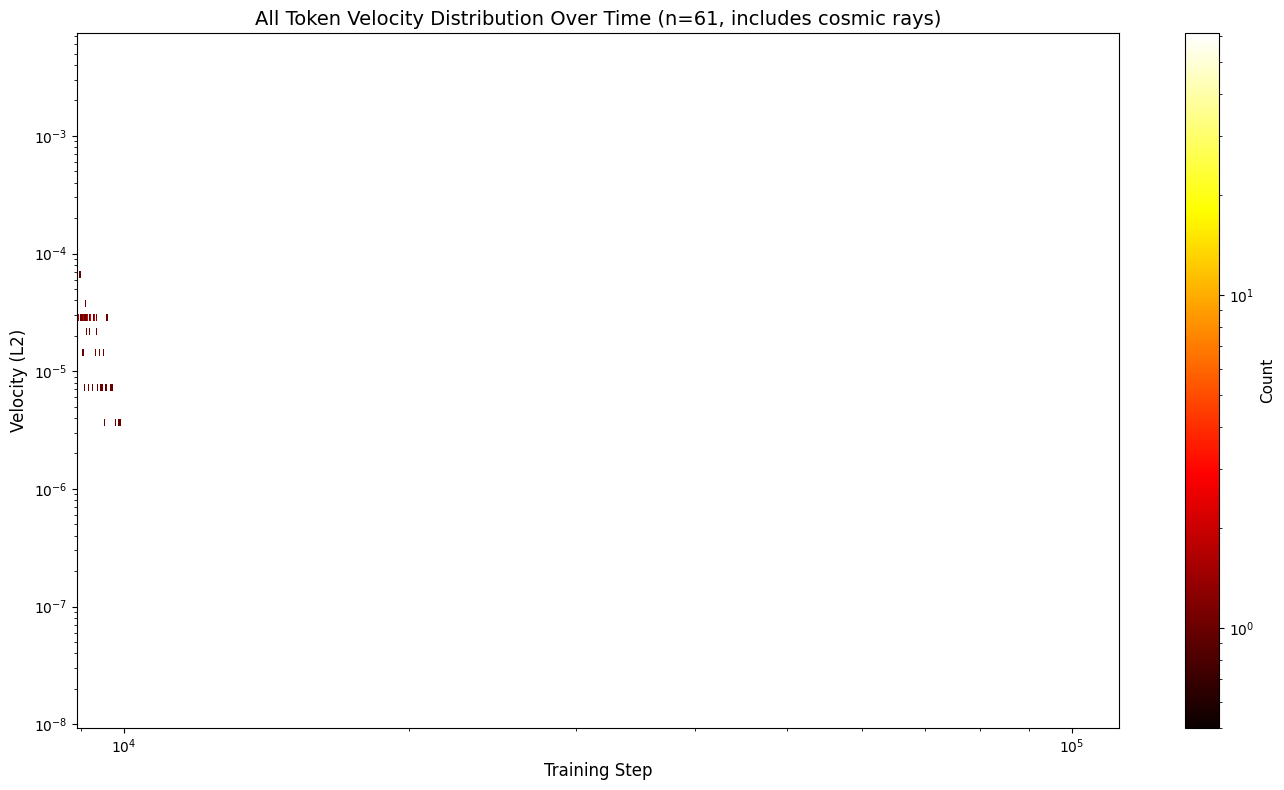


✓ Heatmap complete


In [17]:
print("Building velocity distribution heatmap for all tokens...")

# Find velocity range
v_min = all_velocities.min().item()
v_max = all_velocities.max().item()

bins_all = np.logspace(np.log10(v_min + epsilon), np.log10(v_max + epsilon), VELOCITY_BINS)

# Compute histogram at each timestep
heatmap_all = np.zeros((n_recorded, VELOCITY_BINS - 1))

for t in range(n_recorded):
    velocities_at_t = all_velocities[t].numpy()
    hist, _ = np.histogram(velocities_at_t, bins=bins_all)
    heatmap_all[t] = hist

# Plot
fig, ax = plt.subplots(figsize=(14, 8), dpi=DPI)

im = ax.pcolormesh(recorded_steps, bins_all[:-1], heatmap_all.T, 
                    cmap='hot', norm=LogNorm(vmin=0.5, vmax=heatmap_all.max()), 
                    shading='auto')

ax.set_xlabel('Training Step', fontsize=12)
ax.set_ylabel('Velocity (L2)', fontsize=12)
ax.set_title(f'All Token Velocity Distribution Over Time (n={n_dead + n_live}, includes cosmic rays)', fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Count', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\n✓ Heatmap complete")

## Statistics

In [18]:
print(f"\n{'='*80}")
print(f"TEMPERATURE STATISTICS (L2 velocity)")
print(f"{'='*80}\n")

print(f"Dead tokens (cosmic-ray-free, n={n_dead}):")
print(f"  Initial (step {recorded_steps[0]}):")
print(f"    Mean: {dead_mean[0]:.6e}")
print(f"    Median: {dead_median[0]:.6e}")
print(f"    90th percentile: {dead_p90[0]:.6e}")
print(f"    Max: {dead_max[0]:.6e}")

print(f"\n  Final (step {recorded_steps[-1]}):")
print(f"    Mean: {dead_mean[-1]:.6e}")
print(f"    Median: {dead_median[-1]:.6e}")
print(f"    90th percentile: {dead_p90[-1]:.6e}")
print(f"    Max: {dead_max[-1]:.6e}")

print(f"\n  Cooling ratio (final/initial):")
print(f"    Mean: {dead_mean[-1] / dead_mean[0]:.6f}")
print(f"    Median: {dead_median[-1] / dead_median[0]:.6f}")

print(f"\nLive tokens (includes cosmic rays, n={n_live}):")
print(f"  Initial (step {recorded_steps[0]}):")
print(f"    Mean: {live_mean[0]:.6e}")
print(f"    Median: {live_median[0]:.6e}")
print(f"    90th percentile: {live_p90[0]:.6e}")
print(f"    Max: {live_max[0]:.6e}")

print(f"\n  Final (step {recorded_steps[-1]}):")
print(f"    Mean: {live_mean[-1]:.6e}")
print(f"    Median: {live_median[-1]:.6e}")
print(f"    90th percentile: {live_p90[-1]:.6e}")
print(f"    Max: {live_max[-1]:.6e}")

print(f"\n  Cooling ratio (final/initial):")
print(f"    Mean: {live_mean[-1] / live_mean[0]:.6f}")
print(f"    Median: {live_median[-1] / live_median[0]:.6f}")

print(f"\nCosmic ray contamination:")
print(f"  Live mean / Dead mean (initial): {live_mean[0] / dead_mean[0]:.2f}x")
print(f"  Live median / Dead median (initial): {live_median[0] / dead_median[0]:.2f}x")
print(f"  Live mean / Dead mean (final): {live_mean[-1] / dead_mean[-1]:.2f}x")
print(f"  Live median / Dead median (final): {live_median[-1] / dead_median[-1]:.2f}x")

print(f"\n{'='*80}")


TEMPERATURE STATISTICS (L2 velocity)

Dead tokens (cosmic-ray-free, n=51):
  Initial (step 0):
    Mean: 8.006398e-03
    Median: 8.006845e-03
    90th percentile: 8.007801e-03
    Max: 8.008757e-03

  Final (step 10000):
    Mean: 0.000000e+00
    Median: 0.000000e+00
    90th percentile: 0.000000e+00
    Max: 0.000000e+00

  Cooling ratio (final/initial):
    Mean: 0.000000
    Median: 0.000000

Live tokens (includes cosmic rays, n=10):
  Initial (step 0):
    Mean: 8.004586e-03
    Median: 8.000121e-03
    90th percentile: 8.014983e-03
    Max: 8.014983e-03

  Final (step 10000):
    Mean: 0.000000e+00
    Median: 0.000000e+00
    90th percentile: 0.000000e+00
    Max: 0.000000e+00

  Cooling ratio (final/initial):
    Mean: 0.000000
    Median: 0.000000

Cosmic ray contamination:
  Live mean / Dead mean (initial): 1.00x
  Live median / Dead median (initial): 1.00x
  Live mean / Dead mean (final): nanx
  Live median / Dead median (final): nanx



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_40275/909098952.py:42: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  Live mean / Dead mean (final): {live_mean[-1] / dead_mean[-1]:.2f}x")
/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_40275/909098952.py:43: RuntimeWarning: invalid value encountered in scalar divide
  print(f"  Live median / Dead median (final): {live_median[-1] / dead_median[-1]:.2f}x")


## Interpretation

**Key findings:**

1. **Dead token temperature** measures pure ambient thermal agitation, free from cosmic ray contamination. This is the "true" temperature of the primordial atom.

2. **Median is robust** to the occasional cosmic ray hit. Dead and live medians should be similar (both measure typical token behavior).

3. **Mean is inflated** for live tokens by the occasional huge kick when they're predicted correctly.

4. **The heatmap** shows velocity distribution evolution:
   - Dead tokens: unimodal, cooling monotonically
   - All tokens: bimodal structure (bulk at low velocity + rare high-velocity outliers)

5. **Cooling timescale** can be estimated from exponential decay of median temperature.

**Physical picture:**
- The primordial atom is a thermal system cooling exponentially
- Dead tokens give us a clean thermometer
- Live tokens occasionally get cosmic ray hits that eject them
- The ambient temperature drops as gradients decay
- Eventually the atom freezes (T → 0) when updates fall below quantization threshold